In [1]:
import numpy as np
from qiskit.quantum_info import random_clifford, Pauli

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

def tensor_prod(*tensors):
    if len(tensors) == 2:
        return np.kron(tensors[0], tensors[1])
    else:
        return np.kron(tensors[0], tensor_prod(*tensors[1:]))
    
def hermitian(matrix):
    return np.allclose(matrix, matrix.conj().T)

def trace_one(matrix):
    return np.isclose(np.trace(matrix), 1)

def positive_semi_definite(matrix, tol=1e-8):
    return np.all(np.linalg.eigvals(matrix) + tol >= 0)

def is_legal(matrix):
    return hermitian(matrix) and trace_one(matrix) and positive_semi_definite(matrix)

def int_to_bin_list(n, length):
    bin_list = np.zeros(length)
    bin_list[n] = 1
    return bin_list

def single_sample(prob_list):
    assert np.isclose(sum(prob_list), 1), "probability does not sum up to 1"
    rd = np.random.random()
    inf, sup = 0, 0
    for i, e in enumerate(prob_list):
        sup += e
        if inf <= rd <= sup:
            return i
        else:
            inf = sup
    raise ValueError("random value does not meet any interval")

class QuantumState():
    def __init__(self, num_qubits:int, num_shots:int, batch_size:int, pauli_observables:list, veri:bool):
        self._num_qubits = num_qubits
        self._observables = pauli_observables
        self._batch_size = batch_size
        self._num_shots = num_shots
        self._veri = veri
        self._dm = None
        self._entangled = None
        
    @property
    def dm(self):
        return self._dm
    
    @dm.setter
    def dm(self, new_dm):
        if not (self._veri or is_legal(new_dm)):
            raise ValueError("density matrix is not physical")
        else:
            self._dm = new_dm
    
    def set_dm(self):
        raise NotImplementedError("without information to construct density matrix")
    
    def random_evolve(self):
        self._U = random_clifford(self._num_qubits).to_matrix()
        self._dm = self._U @ self.dm @ np.conj(self._U).T
    
    def single_shot_measure(self):
        prob_list = [self._dm[i, i] for i in range(2 ** self._num_qubits)]
        single_shot_state = int_to_bin_list(single_sample(prob_list), 2 ** self._num_qubits)
        del self._dm
        self._state = single_shot_state
    
    def reconstruct_dm(self):
        dim = 2 ** self._num_qubits
        return (dim + 1) * (np.conj(self._U).T @ np.outer(self._state, self._state) @ self._U) - np.eye(dim)

    # def classical_shadow(self):
    #     shadows = {obs: [] for obs in self._observables}
    #     temp_shadows = {obs: [] for obs in self._observables}
    #     dm_copy = self._dm
    #     for _ in range(self._num_shots // self._batch_size):
    #         for _ in range(self._batch_size):
    #             self._dm = dm_copy
    #             self.random_evolve()
    #             self.single_shot_measure()
    #             rdm = self.reconstruct_dm()
    #             for k, v in temp_shadows.items():
    #                 v.append(np.trace(Pauli(k).to_matrix() @ rdm))
    #         for k, v in shadows.items():
    #             v.append(np.mean(temp_shadows[k]))
    #         temp_shadows = {obs: [] for obs in self._observables}
    #     del temp_shadows
    #     return {k: np.median(v) for k, v in shadows.items()}
    
    def classical_shadow(self):
        shadows = {obs: [] for obs in self._observables}
        dm_copy = self._dm
        for _ in range(self._num_shots // self._batch_size):
            snapshots = []
            for _ in range(self._batch_size):
                self._dm = dm_copy
                self.random_evolve()
                self.single_shot_measure()
                snapshots.append(self.reconstruct_dm())
            mean = np.mean(np.stack(snapshots), axis=0)
            for k, v in shadows.items():
                v.append(np.trace(Pauli(k).to_matrix() @ mean))
        return {k: np.median(v) for k, v in shadows.items()}
    
def partial_transpose(matrix):
    if matrix.shape != (4, 4):
        raise ValueError("Input matrix must be 4x4.")
    result = np.zeros((4, 4), dtype=matrix.dtype)
    for i in range(2):
        for j in range(2):
            for k in range(2):
                for l in range(2):
                    result[2*i + k, 2*j + l] = matrix[2*i + k, 2*j + l]
                    result[2*i + k, 2*j + l] = matrix[2*i + l, 2*j + k]
    return result

state_01 = np.array([[0], 
                     [1],
                     [0],
                     [0]])
state_10 = np.array([[0], 
                     [0],
                     [1],
                     [0]])

class Wernerlikestate(QuantumState):
    def __init__(self, p, theta, phi, num_qubits:int, num_shots:int, batch_size:int, pauli_observables:list, veri:bool):
        super().__init__(num_qubits, num_shots, batch_size, pauli_observables, veri)
        assert num_qubits == 2, "Werner-like states contain only 2 qubits"
        self._p = p
        self._theta = theta
        self._phi = phi
        assert 0 <= p <= 1, "Werner-like state parameter F must lie between 0 and 1"

    def set_dm(self):
        psi = np.cos(self._theta) * state_01 + np.exp(1j * self._phi) * np.sin(self._theta) * state_10
        # if self._p == 1:
        #     if is_legal(tensor_prod(psi, np.conj(psi).T)):
        #         self._dm = tensor_prod(psi, np.conj(psi).T)
        #         return self._dm
        #     else:
        #         raise ValueError("wtf")
        new_dm = self._p * tensor_prod(psi, np.conj(psi).T) + (1 - self._p) * np.eye(4) / 4
        if is_legal(new_dm):
            self._dm = new_dm
            return self._dm
        else:
            print(f"error occur: p={self._p}, theta={self._theta}, phi={self._phi}")
            raise NotImplementedError("density matrix setting wrongly implemented")
    
    @property
    def entangled(self):
        pt_dm = partial_transpose(self._dm)
        return not positive_semi_definite(pt_dm)
                   

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import StandardScaler

In [25]:
dataset = pd.read_csv("output\werner_like_data.csv")

# Extract features and target
X = dataset[['XY', 'ZZ', 'ZI']].values
y = dataset['result'].values

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X).astype(np.float32)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X)
y_tensor = torch.tensor(y).unsqueeze(1).float()  # Add an extra dimension for the labels

# Create a dataset and split into training and validation sets
dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

class ImprovedBinaryClassificationModel(nn.Module):
    def __init__(self):
        super(ImprovedBinaryClassificationModel, self).__init__()
        self.fc1 = nn.Linear(3, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.dropout = nn.Dropout(0.5)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

model = ImprovedBinaryClassificationModel()

criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    for inputs, labels in train_loader:
        optimizer.zero_grad()  # Zero the parameter gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize the weights

        running_loss += loss.item()
        
        # Calculate accuracy
        predicted = (outputs > 0.5).float()  # Convert probabilities to binary predictions
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    # Print statistics
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct_predictions / total_samples
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}, Accuracy: {epoch_accuracy}')

# Validation
model.eval()
val_loss = 0.0
val_correct_predictions = 0
val_total_samples = 0

with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        
        # Calculate validation accuracy
        predicted = (outputs > 0.5).float()
        val_correct_predictions += (predicted == labels).sum().item()
        val_total_samples += labels.size(0)

val_loss /= len(val_loader)
val_accuracy = val_correct_predictions / val_total_samples
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')


Epoch 1/20, Loss: 0.14611562383912968, Accuracy: 0.9407125
Epoch 2/20, Loss: 0.057984001808586254, Accuracy: 0.9785
Epoch 3/20, Loss: 0.03750318008487645, Accuracy: 0.986375
Epoch 4/20, Loss: 0.02980573901885889, Accuracy: 0.989175
Epoch 5/20, Loss: 0.02543276343469983, Accuracy: 0.990925
Epoch 6/20, Loss: 0.023652451820313034, Accuracy: 0.991425
Epoch 7/20, Loss: 0.021907621225286947, Accuracy: 0.992425
Epoch 8/20, Loss: 0.020840951325328105, Accuracy: 0.99255
Epoch 9/20, Loss: 0.020863209101794088, Accuracy: 0.9927125
Epoch 10/20, Loss: 0.01951467954165043, Accuracy: 0.993275
Epoch 11/20, Loss: 0.019181493763035795, Accuracy: 0.993225
Epoch 12/20, Loss: 0.019133749609896836, Accuracy: 0.9931625
Epoch 13/20, Loss: 0.017488397163184653, Accuracy: 0.9938875
Epoch 14/20, Loss: 0.017395299430117184, Accuracy: 0.9937625
Epoch 15/20, Loss: 0.01658000994606581, Accuracy: 0.994175
Epoch 16/20, Loss: 0.016337970184160604, Accuracy: 0.9938625
Epoch 17/20, Loss: 0.016574209746873323, Accuracy: 0

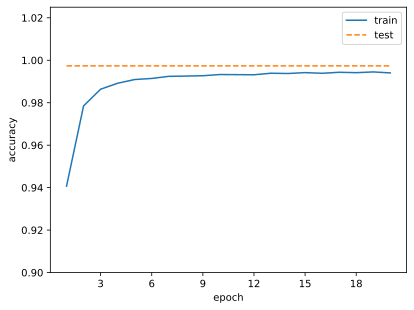

In [64]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots()
xdata = np.arange(1, 21)
ydata = [0.9407125, 0.9785, 0.986375, 0.989175, 0.990925, 0.991425, 0.992425, 0.99255, 0.9927125, 0.993275, 0.993225, 
         0.9931625, 0.9938875, 0.9937625, 0.994175, 0.9938625, 0.9943375, 0.99415, 0.9945, 0.9940375]
yvdata = [0.99735] * len(xdata)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(xdata, ydata, label='train')
ax.plot(xdata, yvdata, linestyle='--', label='test')
ax.set_xlabel('epoch')
ax.set_ylabel('accuracy')
ax.set_ylim(.9, 1.025)
ax.legend()
fig.savefig('output/fig3.png', dpi=240)
plt.show()

In [39]:
from IPython.display import clear_output, display

# Initial parameters
ps = np.linspace(0, 1, 25)
thetas = np.linspace(0, np.pi, 5)
phis = np.linspace(0, 2 * np.pi, 10)
grid1, grid2, grid3 = np.meshgrid(ps, thetas, phis)
parameters = np.vstack([grid1.ravel(), grid2.ravel(), grid3.ravel()]).T
observables = ['XY', 'ZZ', 'ZI']

# Generate dataset from shadow tomography
shadow_data, i = [], 0
for parameter in parameters:
    temp_state = Wernerlikestate(*parameter, 2, 10000, 25, observables, True) # use theoretical value here
    temp_state.set_dm()
    expectations = temp_state.classical_shadow()
    print(expectations)
    expectations = [expectations[o] for o in observables]
    shadow_data.append(np.array(expectations))
    i += 1
    clear_output()
    print(f"{i}/{len(parameters)} state computation finished")
    print(f"{i}th state observables: XY={expectations[0]:.3f}; ZZ={expectations[1]:.3f}; ZI={expectations[2]:.3f}")
clear_output()
shadow_data = pd.DataFrame(shadow_data, columns=observables)
shadow_data.to_csv("output/werner_like_shadow.csv", index=False)

In [42]:
from IPython.display import clear_output, display

# Initial parameters
ps = np.linspace(0, 1, 25)
thetas = np.linspace(0, np.pi, 5)
phis = np.linspace(0, 2 * np.pi, 10)
grid1, grid2, grid3 = np.meshgrid(ps, thetas, phis)
parameters = np.vstack([grid1.ravel(), grid2.ravel(), grid3.ravel()]).T
observables = ['XY', 'ZZ', 'ZI']

# Generate dataset from shadow tomography
shadow_entanglement, i = [], 0
for parameter in parameters:
    temp_state = Wernerlikestate(*parameter, 2, 10000, 25, observables, True) # use theoretical value here
    temp_state.set_dm()
    shadow_entanglement.append(temp_state.entangled)
    i += 1
    clear_output()
    print(f"{i}/{len(parameters)} state computation finished")
    print(f"{i}th state observables: XY={expectations[0]:.3f}; ZZ={expectations[1]:.3f}; ZI={expectations[2]:.3f}")
clear_output()
shadow_data['result'] = shadow_entanglement
shadow_data.to_csv("output/werner_like_shadow_data.csv", index=False)

In [53]:
shadow_dataset = pd.read_csv("output\werner_like_shadow_data.csv")
shadow_X = shadow_dataset[['XY', 'ZZ', 'ZI']].values
shadow_X = np.array([[complex(val).real if isinstance(val, str) else val.real for val in row] for row in shadow_X])
shadow_y = shadow_dataset['result'].values
scaler = StandardScaler()
shadow_X = scaler.fit_transform(shadow_X).astype(np.float32)
shadow_X_tensor = torch.tensor(shadow_X)
shadow_y_tensor = torch.tensor(shadow_y).unsqueeze(1).float()  
shadow_dataset = TensorDataset(shadow_X_tensor, shadow_y_tensor)
shadow_loader = DataLoader(shadow_dataset, batch_size=16, shuffle=False)
model.eval()
shadow_loss = 0.0
shadow_correct_predictions = 0
shadow_total_samples = 0
with torch.no_grad():
    for inputs, labels in shadow_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        shadow_loss += loss.item()
        predicted = (outputs > 0.5).float()
        shadow_correct_predictions += (predicted == labels).sum().item()
        shadow_total_samples += labels.size(0)
shadow_loss /= len(shadow_loader)
shadow_accuracy = shadow_correct_predictions / shadow_total_samples
print(f'Validation Loss: {shadow_loss}, Validation Accuracy: {shadow_accuracy}')

Validation Loss: 6.589158196821213, Validation Accuracy: 0.8968
